In [7]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

from models import Asso, AssoTrans, AssoOpt, AssoIter
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate Boolean matrix

In [8]:
# generate arbitrary Boolean matrix (X)
from generators import BlockDiagonalMatrixGenerator, BlockMatrixGenerator

n_row=1000
n_col=500
k=5
overlap_flag=True
noise=[0.5, 0.2]
size_range=[0.25, 0.75, 0.25, 1.0]

X = BlockMatrixGenerator(m=n_row, n=n_col, k=k, overlap_flag=False, size_range=size_range)
X.generate(seed=1234) # if no seed assigned, use time instead
X.add_noise(noise=noise, seed=1024)
# X.show_matrix(scaling=0.2, title='arbitrary boolean matrix X')

[I] m            : 1000
[I] n            : 500
[I] k            : 5
[I] overlap_flag : False
[I] size_range   : [0.25 0.75 0.25 1.  ]
[I] seed         : 1234
[I] noise        : [0.5 0.2]
[I] seed         : 1024
[I] Using RandomState.


In [9]:
from datasets import MovieLensData

X = MovieLensData(size='100k')
X.load()
X.X

<943x1682 sparse matrix of type '<class 'numpy.int32'>'
	with 100000 stored elements in Compressed Sparse Row format>

In [10]:
from datasets import NoSplit

X_split = NoSplit(X=X.X)
X_train, X_val, X_test = X_split.X_train, X_split.X_val, X_split.X_test

In [11]:
k = 5
tau = 0.30
tau = 0.30
w = [0.75, 0.25]

# empty table
from utils import add_log

# metrics from sklearn is included for checking
metrics = ['Recall', 'Precision', 'Error', 'Accuracy', 'F1', 'recall_score', 'precision_score', 'accuracy_score', 'f1_score']
columns = ['time', 'k', 'tau', 'p_pos', 'p_neg'] + metrics
# df_prediction = pd.DataFrame(columns=columns)
df_reconstruction = pd.DataFrame(columns=columns)

In [12]:
asso = Asso(k=k, tau=tau, w=w)
asso.fit(X_train, X_val, task='reconstruction') # assign X_val and task to activate per-step eval

results = asso.eval(X_val, metrics=metrics, task='reconstruction')
add_log(df_reconstruction, [pd.Timestamp.now(), k, tau, w[0], w[1]] + results, verbose=True)

[I] k            : 5
[I] tau          : 0.3
[I] weights      : [0.75, 0.25]
[I] task         : reconstruction


100%|██████████| 5/5 [07:03<00:00, 84.70s/it]                 


,time,k,tau,p_pos,p_neg,Recall,Precision,Error,Accuracy,F1,recall_score,precision_score,accuracy_score,f1_score
0,2024-01-11 01:28:36.780570,5,0.3,0.75,0.25,0.56851,0.415019,0.077725,0.922275,0.479788,0.56851,0.415019,0.922275,0.479788


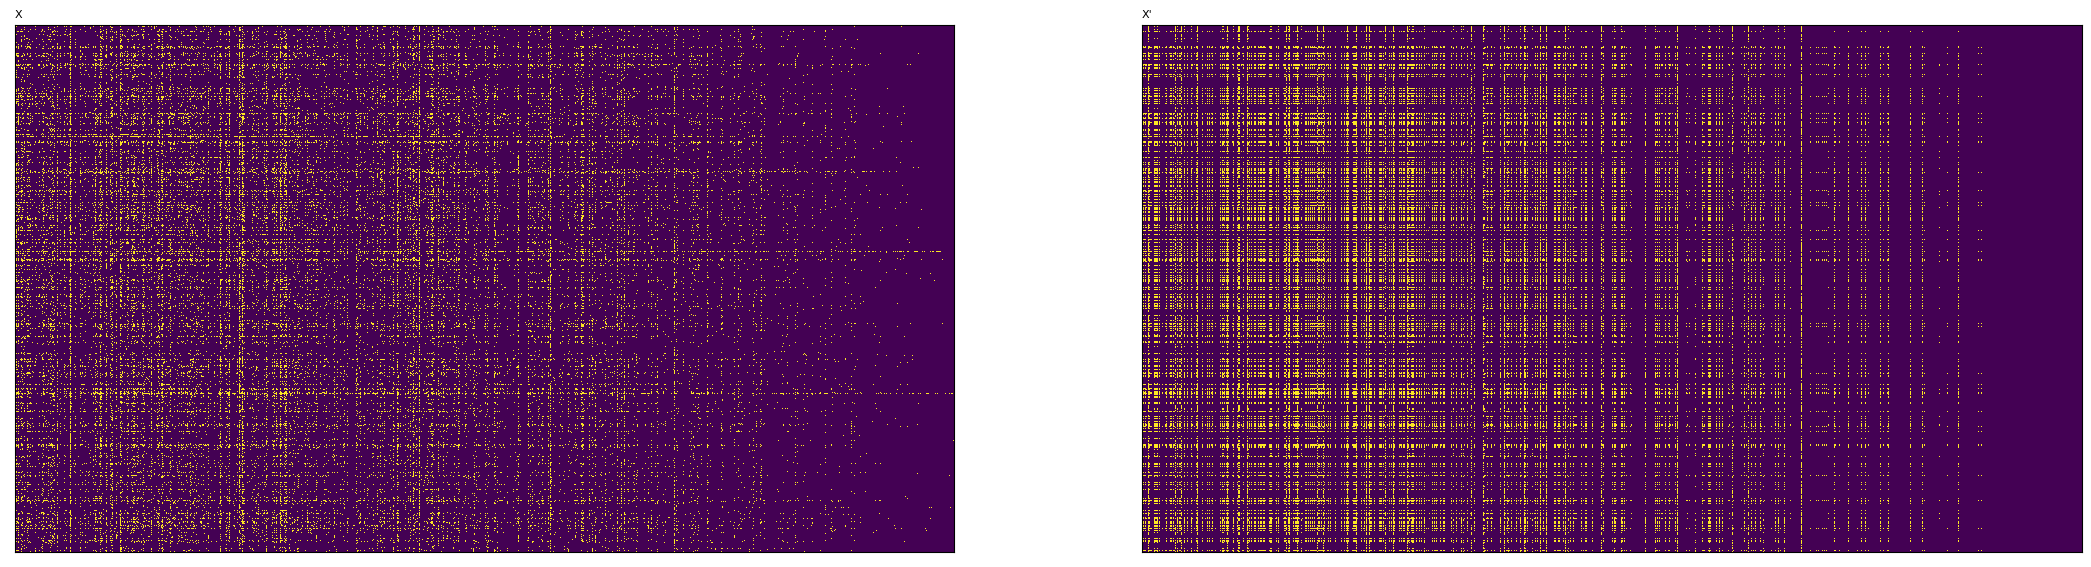

In [13]:
from utils import matmul, to_dense, show_matrix

settings = [(to_dense(X_test), [0, 0], 'X'), 
            (matmul(asso.U, asso.V.T, sparse=False, boolean=True), [0, 1], "X'")]
show_matrix(settings=settings)

### 1. AssoIter

In [14]:
asso = AssoIter(k=k, tau=tau, w=w)
asso.fit(X_train, X_val, task='reconstruction')

results = asso.eval(X_val, metrics=metrics, task='reconstruction')
add_log(df_reconstruction, [pd.Timestamp.now(), k, tau, w[0], w[1]] + results, verbose=True)

[I] k            : 5
[I] tau          : 0.3
[I] weights      : [0.75, 0.25]
[I] task         : reconstruction


100%|██████████| 5/5 [07:09<00:00, 85.95s/it]                 


[I] Refined column i = 0, cover: 22605.0 -> 18040.0, error: 0.07772522485603284 -> 0.06551560216527563.
[I] Refined column i = 1, cover: 18040.0 -> 17044.5, error: 0.07772522485603284 -> 0.062182953939346586.
[I] Refined column i = 2, cover: 17044.5 -> 15018.5, error: 0.07772522485603284 -> 0.06044412612869343.
[I] Refined column i = 3, cover: 15018.5 -> 13556.75, error: 0.07772522485603284 -> 0.05937296280371174.
[I] Refined column i = 4, cover: 13556.75 -> 13184.0, error: 0.07772522485603284 -> 0.05794117239109631.
[I] Refined column i = 0, cover: 13184.0 -> 13751.0, error: 0.05794117239109631 -> 0.05779994779733766.
[I] Refined column i = 1, cover: 13751.0 -> 13863.0, error: 0.05794117239109631 -> 0.05776211978115231.
[I] Refined column i = 2, cover: 13863.0 -> 13863.0, error: 0.05794117239109631 -> 0.05776211978115231.
[I] Refined column i = 3, cover: 13863.0 -> 13863.0, error: 0.05794117239109631 -> 0.05776211978115231.
[I] Refined column i = 4, cover: 13863.0 -> 13856.0, error: 0

,time,k,tau,p_pos,p_neg,Recall,Precision,Error,Accuracy,F1,recall_score,precision_score,accuracy_score,f1_score
0,2024-01-11 01:28:36.780570,5,0.3,0.75,0.25,0.56851,0.415019,0.077725,0.922275,0.479788,0.56851,0.415019,0.922275,0.479788
1,2024-01-11 01:35:59.081977,5,0.3,0.75,0.25,0.23515,0.609008,0.057739,0.942261,0.339292,0.23515,0.609008,0.942261,0.339292


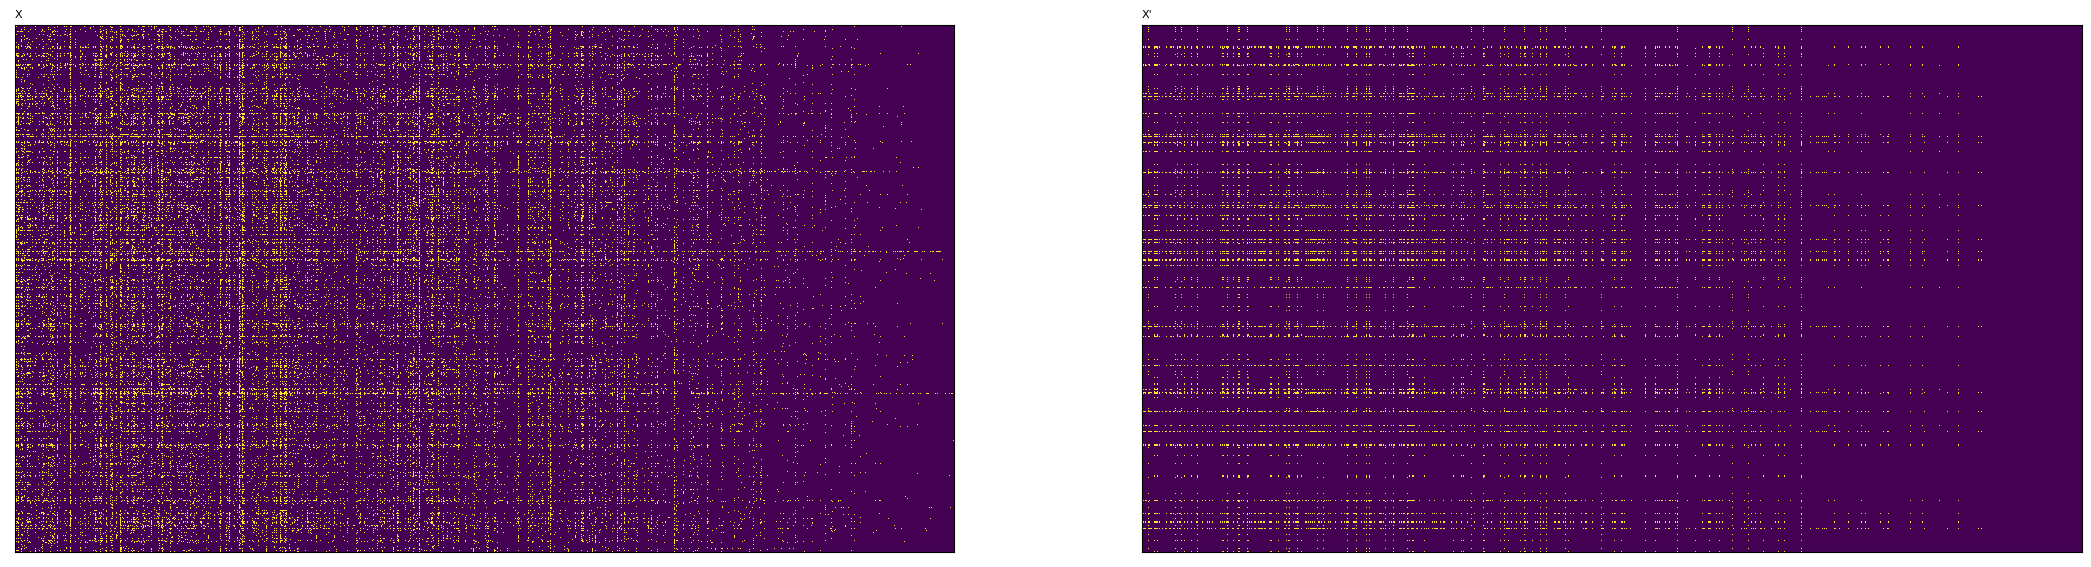

In [15]:
settings = [(to_dense(X_test), [0, 0], 'X'), 
            (matmul(asso.U, asso.V.T, sparse=False, boolean=True), [0, 1], "X'")]
show_matrix(settings=settings)

Since AssoIter uses 'error' as metric during refinement, the result may not be as good as just using Asso. Change the metric to 'cover' in AssoIter.